In [ ]:
# this is certified!
import argparse
import os
import pprint

import gymnasium as gym
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from LCRL.env import DummyVectorEnv
from LCRL.exploration import GaussianNoise
from LCRL.utils.net.common import Net
from LCRL.utils.net.continuous import Actor, Critic
import LCRL.reach_rl_gym_envs as reach_rl_gym_envs
# NOTE: all the reach-avoid gym environments are in reach_rl_gym, the constraint information is output as an element of the info dictionary in gym.step() function

# NOTE: This notebook is used after training the classical reach-avoid value function via DDPG


"""
    We can also learn learn the classical reach-avoid value function by using DDPG under the classical annealed reach-avoid Bellman equation in arXiv:2112.12288:
    python run_training_ddpg.py --task ra_highway_Game-v2 --control-net 512 512 512 --disturbance-net 512 512 512 --critic-net 512 512 512 --gamma 0.95 --epoch 10 --total-episodes 160 --is-game-baseline True
"""
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--task', type=str, default='ra_highway_Game-v2')
    parser.add_argument('--reward-threshold', type=float, default=None)
    parser.add_argument('--seed', type=int, default=0) 
    parser.add_argument('--buffer-size', type=int, default=40000)
    parser.add_argument('--actor-lr', type=float, default=1e-4)
    parser.add_argument('--critic-lr', type=float, default=1e-3)
    parser.add_argument('--gamma', type=float, default=0.95) # 0.95, 1580
    parser.add_argument('--tau', type=float, default=0.005)
    parser.add_argument('--exploration-noise', type=float, default=0.1)
    parser.add_argument('--epoch', type=int, default=10)
    parser.add_argument('--total-episodes', type=int, default=160)
    parser.add_argument('--step-per-epoch', type=int, default=40000)
    parser.add_argument('--step-per-collect', type=int, default=8)
    parser.add_argument('--update-per-step', type=float, default=0.125)
    parser.add_argument('--batch-size', type=int, default=512)
    parser.add_argument('--control-net', type=int, nargs='*', default=[512, 512, 512]) # for control policy
    parser.add_argument('--disturbance-net', type=int, nargs='*', default=[512, 512, 512]) # for disturbance policy
    parser.add_argument('--critic-net', type=int, nargs='*', default=[512, 512, 512]) # for critic net
    parser.add_argument('--training-num', type=int, default=8)
    parser.add_argument('--test-num', type=int, default=100)
    parser.add_argument('--logdir', type=str, default='log')
    parser.add_argument('--render', type=float, default=0.)
    parser.add_argument('--rew-norm', action="store_true", default=False)
    parser.add_argument('--n-step', type=int, default=1)
    parser.add_argument('--continue-training-logdir', type=str, default=None)
    parser.add_argument('--continue-training-epoch', type=int, default=None)
    parser.add_argument('--actor-gradient-steps', type=int, default=1)
    parser.add_argument('--is-game-baseline', type=bool, default=True) # True -> baseline, classical annealed reach-avoid Bellman equation; False -> Our new Reach-RL Bellman equation   
    parser.add_argument('--target-update-freq', type=int, default=400)
    parser.add_argument(
        '--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu'
    )
    parser.add_argument('--actor-activation', type=str, default='ReLU')
    parser.add_argument('--critic-activation', type=str, default='ReLU')
    parser.add_argument('--kwargs', type=str, default='{}')
    args = parser.parse_known_args()[0]
    return args



args=get_args()


env = gym.make(args.task)
args.state_shape = env.observation_space.shape or env.observation_space.n
args.action_shape = env.action_space.shape or env.action_space.n
args.max_action = env.action_space.high[0]

# check if the environment has control and disturbance actions:
assert hasattr(env, 'action1_space') and hasattr(env, 'action2_space'), "The environment does not have control and disturbance actions!"
args.action1_shape = env.action1_space.shape or env.action1_space.n
args.action2_shape = env.action2_space.shape or env.action2_space.n
args.max_action1 = env.action1_space.high[0]
args.max_action2 = env.action2_space.high[0]


# you can also use tianshou.env.SubprocVectorEnv
# train_envs = gym.make(args.task)
train_envs = DummyVectorEnv(
    [lambda: gym.make(args.task) for _ in range(args.training_num)]
)
# test_envs = gym.make(args.task)
test_envs = DummyVectorEnv(
    [lambda: gym.make(args.task) for _ in range(args.test_num)]
)
# seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
train_envs.seed(args.seed)
test_envs.seed(args.seed)
# model

if args.actor_activation == 'ReLU':
    actor_activation = torch.nn.ReLU
elif args.actor_activation == 'Tanh':
    actor_activation = torch.nn.Tanh
elif args.actor_activation == 'Sigmoid':
    actor_activation = torch.nn.Sigmoid
elif args.actor_activation == 'SiLU':
    actor_activation = torch.nn.SiLU

if args.critic_activation == 'ReLU':
    critic_activation = torch.nn.ReLU
elif args.critic_activation == 'Tanh':
    critic_activation = torch.nn.Tanh
elif args.critic_activation == 'Sigmoid':
    critic_activation = torch.nn.Sigmoid
elif args.critic_activation == 'SiLU':
    critic_activation = torch.nn.SiLU

if args.critic_net is not None:
    critic_net = Net(
        args.state_shape,
        args.action_shape,
        hidden_sizes=args.critic_net,
        activation=critic_activation,
        concat=True,
        device=args.device
    )
else:
    critic_net = Net(
        args.state_shape,
        args.action_shape,
        hidden_sizes=args.hidden_sizes,
        activation=critic_activation,
        concat=True,
        device=args.device
    )

critic = Critic(critic_net, device=args.device).to(args.device)
critic_optim = torch.optim.Adam(critic.parameters(), lr=args.critic_lr)

critic1 = Critic(critic_net, device=args.device).to(args.device)
critic1_optim = torch.optim.Adam(critic1.parameters(), lr=args.critic_lr)
critic2 = Critic(critic_net, device=args.device).to(args.device)
critic2_optim = torch.optim.Adam(critic2.parameters(), lr=args.critic_lr)    
if args.control_net is None:
    args.control_net = args.hidden_sizes
if args.disturbance_net is None:
    args.disturbance_net = args.hidden_sizes
if args.critic_net is None:
    args.critic_net = args.hidden_sizes
# import pdb; pdb.set_trace()
log_path = None

if args.is_game_baseline:
    from LCRL.policy import reach_avoid_game_DDPGPolicy_annealing as DDPGPolicy
    print("DDPG under the Reach-Avoid annealed Bellman equation has been loaded!")
else:
    from LCRL.policy import reach_avoid_game_DDPGPolicy as DDPGPolicy
    print("DDPG under Reach-RL Bellman equation has been loaded!")
actor1_net = Net(args.state_shape, hidden_sizes=args.control_net, activation=actor_activation, device=args.device)
actor1 = Actor(
    actor1_net, args.action1_shape, max_action=args.max_action1, device=args.device
).to(args.device)
actor1_optim = torch.optim.Adam(actor1.parameters(), lr=args.actor_lr)
actor2_net = Net(args.state_shape, hidden_sizes=args.disturbance_net, activation=actor_activation, device=args.device)
actor2 = Actor(
    actor2_net, args.action2_shape, max_action=args.max_action1, device=args.device
).to(args.device)
actor2_optim = torch.optim.Adam(actor2.parameters(), lr=args.actor_lr)

policy = DDPGPolicy(
critic,
critic_optim,
tau=args.tau,
gamma=args.gamma,
exploration_noise=GaussianNoise(sigma=args.exploration_noise),
reward_normalization=args.rew_norm,
estimation_step=args.n_step,
action_space=env.action_space,
actor1=actor1,
actor1_optim=actor1_optim,
actor2=actor2,
actor2_optim=actor2_optim,
actor_gradient_steps=args.actor_gradient_steps,
)
if args.is_game_baseline:
    log_path = os.path.join(args.logdir, args.task, 'baseline_ddpg_reach_avoid_actor_activation_{}_critic_activation_{}_game_gd_steps_{}_tau_{}_training_num_{}_buffer_size_{}_c_net_{}_{}_a1_{}_{}_a2_{}_{}_gamma_{}'.format(
    args.actor_activation, 
    args.critic_activation, 
    args.actor_gradient_steps,args.tau, 
    args.training_num, 
    args.buffer_size,
    args.critic_net[0],
    len(args.critic_net),
    args.control_net[0],
    len(args.control_net),
    args.disturbance_net[0],
    len(args.disturbance_net),
    args.gamma)
)
else:
    log_path = os.path.join(args.logdir, args.task, 'ddpg_reach_avoid_actor_activation_{}_critic_activation_{}_game_gd_steps_{}_tau_{}_training_num_{}_buffer_size_{}_c_net_{}_{}_a1_{}_{}_a2_{}_{}_gamma_{}'.format(
    args.actor_activation, 
    args.critic_activation, 
    args.actor_gradient_steps,args.tau, 
    args.training_num, 
    args.buffer_size,
    args.critic_net[0],
    len(args.critic_net),
    args.control_net[0],
    len(args.control_net),
    args.disturbance_net[0],
    len(args.disturbance_net),
    args.gamma)
)


log_path = log_path+'/noise_{}_actor_lr_{}_critic_lr_{}_batch_{}_step_per_epoch_{}_kwargs_{}_seed_{}'.format(
        args.exploration_noise, 
        args.actor_lr, 
        args.critic_lr, 
        args.batch_size,
        args.step_per_epoch,
        args.kwargs,
        args.seed
    )



DDPG under the Reach-Avoid annealed Bellman equation has been loaded!


In [2]:
color_list = [
    "#ff910a",  # Original color 1
    "#828282",  # Original color 2
    "#1c9993",  # Original color 3
    "#B4259A",  # Original color 4
    "#B02418",  # Original color 5
    "#99331c",  # New color 1 (Complementary to #1c9993)
    "#ffa50a",  # New color 2 (Analogous to #ff910a)
    "#25B49A",   # New color 3 (Triadic to #B4259A)
    "#4A90E2"
]

In [2]:
# data reloading module:
epoch_id = 820
envs = gym.make(args.task)
# NOTE! You can define the log path in next line:
# log_path = ""
# check if the log path exists
if os.path.exists(log_path):
    policy.load_state_dict(torch.load(log_path+'/epoch_id_{}/policy.pth'.format(epoch_id)))
    print("policy loaded!")
else:
    print("log_path does not exist!")


policy loaded!


In [3]:
from LCRL.data import Batch


def find_a(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy(tmp_batch, model = "actor_old").act
    act = policy.map_action(tmp).cpu().detach().numpy().flatten()
    return act

def evaluate_V(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy.critic_old(tmp_batch.obs, policy(tmp_batch, model="actor_old").act)
    return tmp.cpu().detach().numpy().flatten()

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import math

  0%|          | 0/1100 [00:00<?, ?it/s]

/tmp/ipykernel_37897/3248348029.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V[ii,jj] = evaluate_V( tmp_point )
100%|██████████| 1100/1100 [01:47<00:00, 10.25it/s]


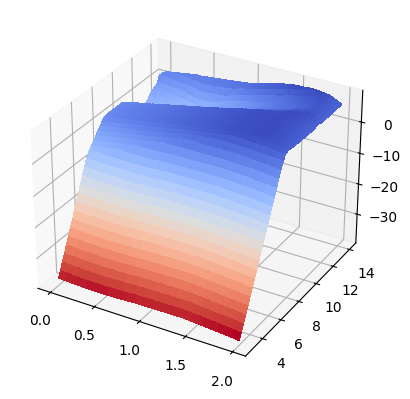

In [4]:
from tqdm import tqdm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# plt.rcParams['font.family'] = 'Times New Roman'
dx = 0.01
dy = 0.01
min_x = 0
max_x = 2
min_y = 3
max_y = 14
x = np.arange(min_x, max_x, dx)
y = np.arange(min_y, max_y, dy)
X, Y = np.meshgrid(x, y)
size_x = len(x)
size_y = len(y)
V = np.zeros((X.shape))

car1_x = 0.5
car1_y = 13
car1_vy = 1.2
ego_v = 1.6
ego_theta = np.pi/2
car2_x = 1.5
car2_y = 6
car2_vy = 1.2

for ii in tqdm(range(V.shape[0])):
    for jj in range(V.shape[1]):
        tmp_point = torch.tensor([
            car1_x, car1_y, car1_vy, 
            X[ii,jj], Y[ii,jj], ego_v, ego_theta,
            car2_x, car2_y, car2_vy
            ])
        V[ii,jj] = evaluate_V( tmp_point )
        
surf = ax.plot_surface(X, Y, V, cmap=cm.coolwarm_r,
                        linewidth=0, antialiased=False)

In [5]:
binary_pure_V = np.zeros(V.shape)
binary_pure_V[V > 0] = 1
X_pure = X
Y_pure = Y 

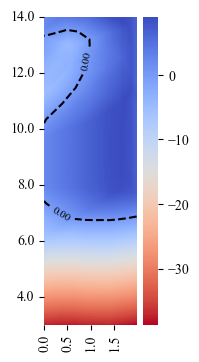

In [7]:
import seaborn as sns

x_interval = 50
y_interval = 200

fig, ax = plt.subplots(figsize=(1.5, 4))
V_flipped = np.flipud(V)
sns.heatmap(V_flipped, annot=False, cmap=cm.coolwarm_r, ax=ax,
            xticklabels=np.round(x[::x_interval], 2),
            yticklabels=np.round(y[::-y_interval], 1))
x_ticks = np.arange(0, len(x), x_interval)
y_ticks = np.arange(0, len(y), y_interval)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xticklabels(np.round(x[::x_interval], 2))
ax.set_yticklabels(np.round(y[::-y_interval]+dy, 1))

contours = ax.contour((X-min_x)*100, (Y-min_y)*100, V_flipped, levels=[0], colors='black', linestyles='dashed')
ax.clabel(contours, inline=True, fontsize=8, fmt="%.2f")
plt.show()
